# Анализ данных разработчика мобильных игр.

## Задачи.
1. Написать функцию для подсчета Retention по дням от даты регистрации игрока.
2. На основе имеющихся данных A/B тестирования наборов акционных предложений нужно определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy.stats as ss
import pingouin as pg
from tqdm import tqdm

# 1. Функция для подсчета Retention.

In [2]:
# Подгрузим данные по регистрациям

reg_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/IXfIB4XcJVjTBA'

In [3]:
reg = pd.read_csv(reg_path, sep=';')

In [4]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
# Подгрузим данные по авторизациям

auth_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iBTc5cYQStvm_w'

In [7]:
auth = pd.read_csv(auth_path, sep=';')

In [8]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Создадим 3 функции для разных целей:
1. Пользователь задает способ расчета, период регистраций и день Retention. Функция возвращает среднее значение Retention для заданных параметров.
2. Пользователь задает способ расчета, период регистраций и временной отрезок для Retention. Функция возвращает график с динамикой за выбранный период.
3. Пользователь задает способ расчета, период регистраций и временной отрезок для Retention. Функция возвращает когортный анализ Retention.

Общий план работы функций:
1. Объединить 2 аргумента (датафрейма).
2. Завести колонку с кол-вом прошедших дней с даты регистрации. 
3. Преобразовать данные в финальную таблицу в зависимости от типа задачи.
4. Извлечь из таблицы необходимые данные и/или визуализировать.

Сначала проверим код для каждого этапа на небольших выборках, затем соберем функции.

In [10]:
# Объединим данные

r_df = auth.merge(reg, on='uid')

Из множества видов выберем классический N-Day Retention, т.к. он наиболее распространен и универсален, а мобильные игры предполагают, в основном, короткие партии, различные поощрения за вход в игру и/или действия в ней, чтобы пользователи заходили каждый день, хотя бы на короткий промежуток времени, поэтому именно этот вариант нам подходит лучше всего. При наличии возможности собрать требования, можно было бы также предложить Return Retention.

Рассчитывать будем 2мя способами:
1. Календарным: перевести время из UNIX в обычный формат и смотреть по датам, сколько дней прошло.
2. На основе окон в 24 часа: оставить текущий формат и отсчитывать по 24 часа.

Когорты будем смотреть по дням, т.к. функции нужны для частого использования. В некоторых ситуациях может быть правильней делить пользователей по неделям или месяцам, например, когда идут какие-то акции, внутриигровые события, тестируется новый патч, и мы хотим видеть их влияние на Retention, но для таких временных горизонтов большого смысла писать функции нет, несколько раз в год можно корректировать код под каждую ситуацию и различные задачи.

In [11]:
# Календарный расчет

# Создадим тестовый ДФ меньшего объема

calendar = r_df.head(100000).copy()

In [12]:
calendar.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [13]:
# Переведем время из UNIX в формат дат

calendar.auth_ts = pd.to_datetime(calendar.auth_ts,
                                  unit='s').dt.date
calendar.reg_ts = pd.to_datetime(calendar.reg_ts,
                                 unit='s').dt.date

In [14]:
# Создадим колонку с кол-вом прошедших дней

calendar['days_passed'] = (calendar.auth_ts 
                           - calendar.reg_ts).dt.days

In [15]:
calendar.head()

,auth_ts,uid,reg_ts,days_passed
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-25,2,1999-07-22,3
3,1999-07-31,2,1999-07-22,9
4,1999-08-05,2,1999-07-22,14


In [16]:
# Посчитаем, сколько пользователей вернулось на свой N-day

calendar = calendar.groupby(['reg_ts', 
                             'days_passed'], 
                            as_index=False).uid.nunique()

In [17]:
calendar.head()

,reg_ts,days_passed,uid
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,3,1
3,1999-07-22,9,1
4,1999-07-22,14,1


In [18]:
# Разобьем пользователей на когорты, 
# покажем кол-во возвратов по дням

cohorts_c = calendar.pivot(index='reg_ts', 
                           columns='days_passed', 
                           values='uid') \
                    .fillna(0) \
                    .astype(int)

In [19]:
cohorts_c.head()

days_passed,0,1,2,3,4,5,6,7,8,9,...,7701,7704,7706,7709,7712,7716,7720,7721,7727,7729
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-22,1,0,0,1,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
2000-01-13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


На основе этого ДФа можно получить все необходимые нам данные для расчета календарным путем.

Создадим ДФ для расчета по 24-часовым окнам.

In [20]:
# Расчет по окнам

window = r_df.head(100000).copy()

In [21]:
window.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [22]:
# Сохраним размер окна в переменную

secs_in_day = 24 * 60 * 60

In [23]:
# Создадим колонку с кол-вом прошедших окон

window['days_passed'] = (window.auth_ts 
                         - window.reg_ts) \
                            // secs_in_day

In [24]:
window.head()

,auth_ts,uid,reg_ts,days_passed
0,911382223,1,911382223,0
1,932683089,2,932683089,0
2,932921206,2,932683089,2
3,933393015,2,932683089,8
4,933875379,2,932683089,13


In [25]:
# Переведем время регистрации из UNIX в формат дат

window.reg_ts = pd.to_datetime(window.reg_ts,
                               unit='s').dt.date

In [26]:
# Посчитаем, сколько пользователей вернулось на свой N-day

window = window.groupby(['reg_ts', 
                         'days_passed'], 
                        as_index=False).uid.nunique()

In [27]:
window.head()

,reg_ts,days_passed,uid
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,2,1
3,1999-07-22,8,1
4,1999-07-22,13,1


In [28]:
# Разобьем пользователей на когорты, 
# покажем кол-во возвратов по дням

cohorts_w = window.pivot(index='reg_ts', 
                         columns='days_passed', 
                         values='uid') \
                  .fillna(0) \
                  .astype(int)

In [29]:
cohorts_w.head()

days_passed,0,1,2,3,4,5,6,7,8,9,...,7700,7703,7705,7708,7711,7715,7719,7720,7726,7728
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-22,1,0,1,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
2000-01-13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Теперь, когда исходные данные готовы, пройдем по функциям, которые хотим реализовать.

Чтобы не повторяться, все задачи будем выполнять на календарном ДФе.

Решим следующие задачи для самопроверки:
1. Retention 7 дня для пользователей, зарегистрировавшихся в 2002 году.
2. График Retention первой 1й недели для пользователей, зарегистрировавшихся в 2003 году.
3. Для пользователей, зарегистрировавшихся в последнем квартале 2004 года, показать когорты и Retention первых 2х недель.

In [30]:
# Retention 7го дня

# За сегодняшнюю дату возьмем последнюю из ДФа

today = pd.to_datetime(r_df.head(100000).auth_ts.max(), 
                       unit='s').date()

При расчете среднего Retention и визуализации его динамики по дням будем брать только те когорты, у которых физически мог наступить N-Day, в противном случае при расчетах мы будем учитывать разные наборы когорт для разных дней и/или учитывать нулевые значения, которых нет и быть не могло.

In [31]:
# Уберем когорты, у которых еще не прошло 7 дней,
# оставим регистрации только за 2002 год

day_7 = cohorts_c.copy()[((today - cohorts_c.index) >= '7 days') 
                         & ((cohorts_c.index < datetime.date(2003, 1, 1)) 
                         & (cohorts_c.index > datetime.date(2001, 12, 31)))]

In [32]:
# Посчитаем Retention

((day_7[7].sum() / day_7[0].sum()) * 100).round(1)

20.0

В урезанном ДФе Retention 7 дня для пользователей, зарегистрировавшихся в 2002 году, равен 20%.

In [33]:
# График Retention первой недели

# Уберем когорты, у которых не прошло недели,
# Оставим регистрации за 2003 год

week_1 = cohorts_c.copy()[((today - cohorts_c.index) >= '7 days') 
                          & ((cohorts_c.index < datetime.date(2004, 1, 1)) 
                          & (cohorts_c.index > datetime.date(2002, 12, 31)))]

In [34]:
# Создадим список со значениями Retention,
# зададим отрезок времени,
# посчитаем Retention для каждого дня

r_results = []
days = 7

for i in range(days + 1):
    r = ((week_1[i].sum() / week_1[0].sum()) * 100).round(1)
    r_results.append(r)

In [35]:
# Создадим список с днями

r_days = list(range(days + 1))

In [36]:
# Соберем ДФ

r_graph = pd.DataFrame({'n_day': r_days,
                        'retention': r_results})

In [37]:
r_graph

,n_day,retention
0,0,100.0
1,1,0.0
2,2,5.0
3,3,10.0
4,4,5.0
5,5,0.0
6,6,10.0
7,7,15.0


[Text(0.5, 0, 'N-Day'), Text(0, 0.5, 'Retention, %')]

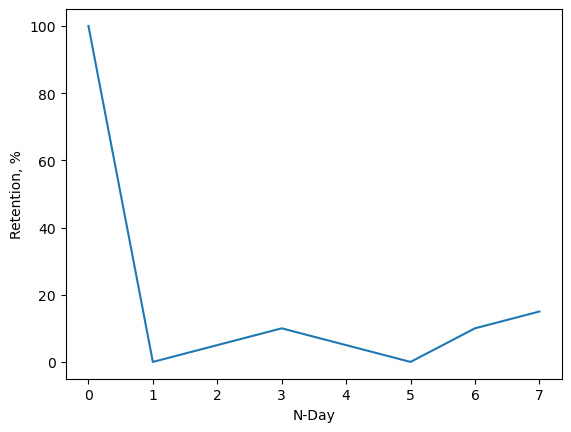

In [38]:
# Построим график

g_r7 = sns.lineplot(data=r_graph,
                    x='n_day',
                    y='retention')
# Подпишем оси
g_r7.set(xlabel='N-Day',
         ylabel='Retention, %')

На графике динамика Retention первой 1й недели для пользователей, зарегистрировавшихся в 2003 году.

In [39]:
# Когортный анализ Retention

# Выберем когорты за последний квартал 2004го года 
week_2 = cohorts_c.copy()[(cohorts_c.index < datetime.date(2005, 1, 1)) 
                          & (cohorts_c.index > datetime.date(2004, 9, 30))]

In [40]:
# Переведем значения в проценты,
# отфильтруем только нужные N-Days

week_2 = week_2.div(week_2[0], axis=0) \
               .mul(100) \
               .round(1)[list(range(0, 15))]

In [41]:
# Для когорт, которые еще не дошли до соответствующих дней,
# меняем 0 на пустые значения

for i in range(len(week_2.index)):
    for j in range(len(week_2.columns)):
        if week_2.index[i] + pd.Timedelta(days=j) > today:
            week_2.loc[week_2.index[i], week_2.columns[j]] = np.nan

In [42]:
week_2.head()

days_passed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2004-10-01,100.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2004-10-10,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-10-19,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2004-10-28,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-11-05,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0, '')

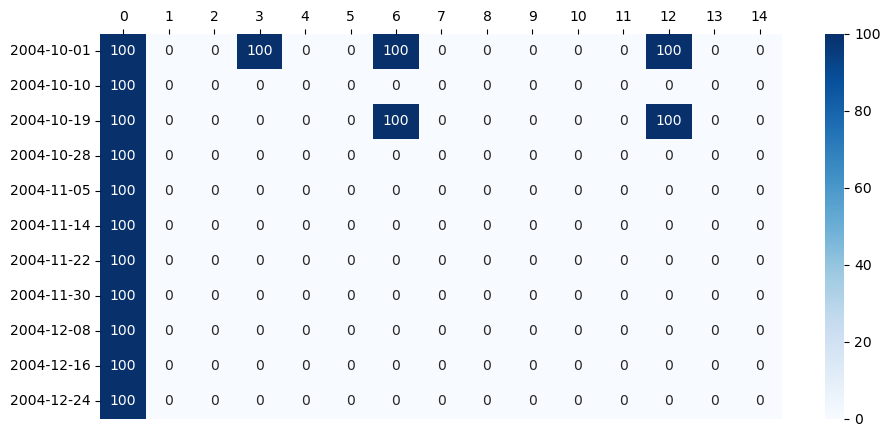

In [43]:
# Визуализируем данные

# Отрегулируем размер
f, ax = plt.subplots(figsize=(11, 5))

# Создадим график,
# подпишем значения,
# зададим синий цвет, т.к. уже есть график синего цвета
# выведем значения в привычном формате

g_w2 = sns.heatmap(week_2, annot=True, cmap='Blues', fmt='g')

# Перенесем подписи оси Х наверх
g_w2.xaxis.tick_top()

# Уберем лэйблы
g_w2.set(xlabel=None, ylabel=None)

# Повернем подписи оси Y
plt.yticks(rotation=0)

# Уберем доп. текст Matplotlib
g_w2.text(0, 0, '')

По графикам такого формата можно сравнивать Retention у разных когорт.

### Финальный код функций.

Внесем несколько корректировок в функции:
1. Профильтруем даты регистраций в самом начале, чтобы ускорить работу функции.
2. Для оконного способа подсчета при фильтрации по возможности наступления N-Day нужно добавить 1 день, чтобы абсолютно у всех пользователей, вошедших в когорту, в т.ч. зарегистрировавшихся в 23-59, прошло (N-Day * 24 часа).
3. При небольших выборках в некоторые дни может не быть возвратов, соответственно и колонок, поэтому добавим except на этот случай, чтобы отображался 0. 
4. Добавим различные информационные сообщения и try-exept'ы, чтобы пользователи вводили корректные данные и получали фидбэк, если что-то пошло не так.

In [44]:
# Функция 1, возвращающая значение Retention N-Day

def retention_nday(reg_path, 
                   auth_path, 
                   r_type, 
                   min_reg, 
                   max_reg, 
                   nday):
    
    '''
Функция принимает следующие аргументы и параметры:
1. Пути к файлам с данными о регистрациях и авторизациях (reg_path, auth_path).
Укажите путь к файлам в двойных или одинарных кавычках.
2. Способ расчета Retention (r_type). 
Укажите в двойных или одинарных кавычках "с" для календарного способа, "w" для оконного.
3. Период регистраций (min_reg, max_reg). 
Укажите в двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд".
4. N-Day Retention (nday). 
Укажите день(цифру), для которого необходимо посчитать Retention. 
    
Функция возвращает значение Retention указанного дня.
'''
    # Загрузим 2 ДФа
    try:
        reg = pd.read_csv(reg_path, sep=';')
        auth = pd.read_csv(auth_path, sep=';')
    except:
        return print('''
Вы ввели неверный(ые) путь(и) к данным о регистрациях и авторизациях 
(reg_path, auth_path). Запустите функцию снова, указав пути к файлам 
в двойных или одинарных кавычках. Для вызова справки по функции 
введите print(retention_nday.__doc__).
''')
    
    # Создадим новую колонку с регистрациями в формате дат
    reg['reg_date'] = pd.to_datetime(reg.reg_ts,
                                     unit='s').dt.date
    
    # Считаем минимальную и максимальную дату регистрации
    try:
        reg_min = datetime.date(int(min_reg.split('-')[0]),
                                int(min_reg.split('-')[1]),
                                int(min_reg.split('-')[2]))
        reg_max = datetime.date(int(max_reg.split('-')[0]),
                                int(max_reg.split('-')[1]),
                                int(max_reg.split('-')[2]))
        
        if reg_min > reg_max:
            return print('''
Минимальная дата регистрации больше максимальной. Запустите функцию 
снова, указав в двойных или одинарных кавычках минимальную и 
максимальную даты регистрации для выборки в формате "гггг-мм-дд". 
Для вызова справки по функции введите print(retention_nday.__doc__).
''')
        
        elif reg_min > reg.reg_date.max() \
             or reg_max < reg.reg_date.min():
            return print('''
Заданный временной отрезок отсутствует в данных о регистрациях. 
Запустите функцию снова, указав в двойных или одинарных кавычках 
минимальную и максимальную даты регистрации для выборки в формате 
"гггг-мм-дд". Для вызова справки по функции введите 
print(retention_nday.__doc__).
            ''')
        
    except:
        return print('''
Вы ввели неверное(ые) значение(я) минимальной и/или максимальной
даты регистрации (min_reg, max_reg). Запустите функцию снова, указав в 
двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд". Для вызова справки по функции 
введите print(retention_nday.__doc__).
''')
    
    # Оставим регистрации только для выбранного периода
    reg = reg[((reg.reg_date <= reg_max) 
              & (reg.reg_date >= reg_min))] 
          
    # Объединим данные
    df = auth.merge(reg, on='uid')
    
    # Сохраним сегодняшнюю дату в переменную
    today = pd.to_datetime('today').date()  
        
    if nday < 0:
        return print('''
Значение N-Day(nday) не может быть ниже нуля. Запустите функцию снова, 
указав день(цифру), для которого необходимо посчитать Retention. Для вызова 
справки по функции введите print(retention_nday.__doc__).
''')
    
    # Считаем N-Day,
    # зададим значение для фильтрации когорт
    try:
        n_day = f'{int(nday)} days'
    except:
        return print('''
Вы ввели неверное значение N-Day(nday). Запустите функцию снова, 
указав день(цифру), для которого необходимо посчитать Retention. Для вызова 
справки по функции введите print(retention_nday.__doc__).
''')
    
    # В зависимости от типа расчета соберем ДФ с когортами
    # Для календарного типа
    if r_type == 'c':
        
        # Создадим колонку с авторизациями в формат дате
        df['auth_date'] = pd.to_datetime(df.auth_ts,
                                    unit='s').dt.date
        
        # Создадим колонку с кол-вом прошедших дней
        df['days_passed'] = (df.auth_date - df.reg_date).dt.days
        
        # Посчитаем, сколько пользователей вернулось на свой N-day
        df = df.groupby(['reg_date', 'days_passed'], 
                        as_index=False).uid.nunique()
        
        # Разобьем пользователей на когорты, покажем кол-во возвратов по дням
        cohorts = df.pivot(index='reg_date', 
                           columns='days_passed', 
                           values='uid') \
                    .fillna(0) \
                    .astype(int)
        
        # Уберем когорты, у которых не мог наступить N-Day
        cohorts = cohorts[(today - cohorts.index) >= n_day]
            
        if cohorts.shape[0] == 0:
            return print('''
В указанном временном промежутке регистраций нет ни одной когорты, у которой 
прошло достаточно дней, чтобы иметь возможность вернуться в заданный N-Day.
''')
    
    # Для оконного типа расчета
    elif r_type == 'w':
        
        # Сохраним размер окна в переменную
        secs_in_day = 24 * 60 * 60
        
        # Создадим колонку с кол-вом прошедших окон
        df['days_passed'] = (df.auth_ts - df.reg_ts) // secs_in_day
        
        # Посчитаем, сколько пользователей вернулось на свой N-day
        df = df.groupby(['reg_date', 'days_passed'], 
                        as_index=False).uid.nunique()
        
        # Разобьем пользователей на когорты, 
        # покажем кол-во возвратов по дням
        cohorts = df.pivot(index='reg_date', 
                           columns='days_passed', 
                           values='uid') \
                    .fillna(0) \
                    .astype(int)
        
        # Уберем когорты, 
        # у которых не мог наступить N-Day
        cohorts = cohorts[(today - cohorts.index) >= f'{int(nday + 1)} days']
    
        if cohorts.shape[0] == 0:
            return print('''
В указанном временном промежутке регистраций нет ни одной когорты, у которой 
прошло достаточно дней, чтобы иметь возможность вернуться в заданный N-Day.
''')
    else:
        return print('''
Вы ввели неверное значение способа расчета Retention (r-type). 
Запустите функцию снова, указав в двойных или одинарных кавычках "с" 
для календарного способа, "w" для оконного. Для вызова справки по функции 
введите print(retention_nday.__doc__).
''')   
    
    # Посчитаем Retention
    try:
        r = ((cohorts[nday].sum() / cohorts[0].sum()) * 100).round(1)
    except:
        return print(f'''
Retention {nday} дня среди пользователей, зарегистрировавшихся в
период с {min_reg} по {max_reg}, составляет 0.0%.
''') 
    
    # Вернем ответ
    return print(f'''
Retention {nday} дня среди пользователей, зарегистрировавшихся в
период с {min_reg} по {max_reg}, составляет {r}%.
''') 

In [45]:
# Проверим работу функции 1

retention_nday(reg_path, 
               auth_path, 
               'c', 
               '2002-01-01', 
               '2002-12-31', 
               7)


Retention 7 дня среди пользователей, зарегистрировавшихся в
период с 2002-01-01 по 2002-12-31, составляет 20.0%.



Часть 1й функции можно выделить в отдельную функцию, чтобы использовать ее во всех 3х, или же ввести еще один параметр, который позволит выводить только ту информацию, которая нужна, но мы не знаем, где и как будут располагаться функции, все ли понадобятся, поэтому на данном этапе просто сделаем 3 независимых самостоятельных конструкции, а при необходимости оптимизируем и сократим код в соответствии с фидбэком заказчика.

In [46]:
# Функция 2, возвращающая график динамики 
# Retention за выбранный период

def retention_graph(reg_path, 
                    auth_path, 
                    r_type, 
                    min_reg, 
                    max_reg, 
                    min_nday,
                    max_nday):
    
    '''
Функция принимает следующие аргументы и параметры:
1. Пути к файлам с данными о регистрациях и авторизациях (reg_path, auth_path).
Укажите путь к файлам в двойных или одинарных кавычках.
2. Способ расчета Retention (r_type). 
Укажите в двойных или одинарных кавычках "с" для календарного способа, "w" для оконного.
3. Период регистраций (min_reg, max_reg). 
Укажите в двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд".
4. Временной отрезок Retention (min_nday, max_nday). 
Укажите минимальный и максимальный N-Day(цифры), для которых необходимо показать динамику Retention. 
    
Функция возвращает график динамики Retention за выбранный период.
'''
    # Загрузим 2 ДФа
    try:
        reg = pd.read_csv(reg_path, sep=';')
        auth = pd.read_csv(auth_path, sep=';')
    except:
        return print('''
Вы ввели неверный(ые) путь(и) к данным о регистрациях и авторизациях 
(reg_path, auth_path). Запустите функцию снова, указав пути к файлам 
в двойных или одинарных кавычках. Для вызова справки по функции 
введите print(retention_graph.__doc__).
''')
    
    # Создадим новую колонку с регистрациями в формате дат
    reg['reg_date'] = pd.to_datetime(reg.reg_ts,
                                     unit='s').dt.date
    
    # Считаем минимальную и максимальную дату регистрации
    try:
        reg_min = datetime.date(int(min_reg.split('-')[0]),
                                int(min_reg.split('-')[1]),
                                int(min_reg.split('-')[2]))
        reg_max = datetime.date(int(max_reg.split('-')[0]),
                                int(max_reg.split('-')[1]),
                                int(max_reg.split('-')[2]))
        
        if reg_min > reg_max:
            return print('''
Минимальная дата регистрации больше максимальной. Запустите функцию 
снова, указав в двойных или одинарных кавычках минимальную и 
максимальную даты регистрации для выборки в формате "гггг-мм-дд". 
Для вызова справки по функции введите print(retention_graph.__doc__).
''')
        
        elif reg_min > reg.reg_date.max() \
             or reg_max < reg.reg_date.min():
            return print('''
Заданный временной отрезок отсутствует в данных о регистрациях. 
Запустите функцию снова, указав в двойных или одинарных кавычках 
минимальную и максимальную даты регистрации для выборки в формате 
"гггг-мм-дд". Для вызова справки по функции введите 
print(retention_graph.__doc__).
            ''')
        
    except:
        return print('''
Вы ввели неверное(ые) значение(я) минимальной и/или максимальной
даты регистрации (min_reg, max_reg). Запустите функцию снова, указав в 
двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд". Для вызова справки по функции 
введите print(retention_graph.__doc__).
''')
    
    # Оставим регистрации только для выбранного периода
    reg = reg[((reg.reg_date <= reg_max) 
              & (reg.reg_date >= reg_min))] 
          
    # Объединим данные
    df = auth.merge(reg, on='uid')
    
    # Сохраним сегодняшнюю дату в переменную
    today = pd.to_datetime('today').date()  
    
    # Проверим N-Days на соответствие условиям
    try:
        if min_nday > max_nday:
            return print('''
Минимальный N-Day больше максимального. Запустите функцию 
снова, указав минимальный и максимальный N-Day(цифры), для которых 
необходимо показать динамику Retention. Для вызова справки по функции 
введите print(retention_graph.__doc__).
''')
        elif min_nday < 0:
            return print('''
N-Day не может быть меньше нуля. Запустите функцию снова, указав 
минимальный и максимальный N-Day(цифры), для которых необходимо 
показать динамику Retention. Для вызова справки по функции 
введите print(retention_graph.__doc__).
''')
        
    except:
        return print('''
Вы ввели неверное(ые) значение(я) N-Day (min_nday, max_nday). Запустите 
функцию снова, указав минимальный и максимальный N-Day(цифры), для которых 
необходимо показать динамику Retention. Для вызова справки по функции 
введите print(retention_graph.__doc__).
''')
    
    # Зададим значение N-Day Для фильтрации когорт
    n_day = f'{int(max_nday)} days'
    
    # В зависимости от типа расчета соберем ДФ с когортами
    # Для календарного типа расчета
    if r_type == 'c':
        
        # Создадим колонку с авторизациями в формат дате
        df['auth_date'] = pd.to_datetime(df.auth_ts,
                                    unit='s').dt.date
        
        # Создадим колонку с кол-вом прошедших дней
        df['days_passed'] = (df.auth_date - df.reg_date).dt.days
        
        # Посчитаем, сколько пользователей вернулось на свой N-day
        df = df.groupby(['reg_date', 'days_passed'], 
                        as_index=False).uid.nunique()
        
        # Разобьем пользователей на когорты, 
        # покажем кол-во возвратов по дням
        cohorts = df.pivot(index='reg_date', 
                           columns='days_passed', 
                           values='uid') \
                    .fillna(0) \
                    .astype(int)
        
        # Уберем когорты, у которых не мог наступить N-Day
        cohorts = cohorts[(today - cohorts.index) >= n_day]
            
        if cohorts.shape[0] == 0:
            return print('''
В указанном временном промежутке регистраций нет ни одной когорты, у которой 
прошло достаточно дней, чтобы иметь возможность вернуться в заданный N-Day.
''')
    
    # Для оконного типа расчета
    elif r_type == 'w':
        
        # Сохраним размер окна в переменную
        secs_in_day = 24 * 60 * 60
        
        # Создадим колонку с кол-вом прошедших окон
        df['days_passed'] = (df.auth_ts - df.reg_ts) // secs_in_day
        
        # Посчитаем, сколько пользователей вернулось на свой N-day
        df = df.groupby(['reg_date', 'days_passed'], 
                        as_index=False).uid.nunique()
        
        # Разобьем пользователей на когорты, 
        # покажем кол-во возвратов по дням
        cohorts = df.pivot(index='reg_date', 
                           columns='days_passed', 
                           values='uid') \
                    .fillna(0) \
                    .astype(int)
        
        # Уберем когорты, у которых не мог наступить N-Day
        cohorts = cohorts[(today - cohorts.index) >= f'{max_nday + 1} days']
    
        if cohorts.shape[0] == 0:
            return print('''
В указанном временном промежутке регистраций нет ни одной когорты, у которой 
прошло достаточно дней, чтобы иметь возможность вернуться в заданный N-Day.
''')
    else:
        return print('''
Вы ввели неверное значение способа расчета Retention (r-type). 
Запустите функцию снова, указав в двойных или одинарных кавычках "с" 
для календарного способа, "w" для оконного. Для вызова справки по функции 
введите print(retention_graph.__doc__).
''')   
    
    # Создадим список со значениями Retention,
    # Посчитаем Retention для каждого дня

    r_results = []

    for i in range(min_nday, max_nday + 1):
        try:
            r = ((cohorts[i].sum() / cohorts[0].sum()) * 100).round(1)
        except:
            r = 0
        r_results.append(r)
        
    # Создадим список с днями
    r_days = list(range(min_nday, max_nday + 1))
    
    # Соберем ДФ
    r_graph = pd.DataFrame({'n_day': r_days,
                            'retention': r_results})
    
    # Построим график
    g_r7 = sns.lineplot(data=r_graph,
                        x='n_day',
                        y='retention')
    # Подпишем оси
    g_r7.set(xlabel='N-Day',
             ylabel='Retention, %')
    
    # Вернем график
    return g_r7

<AxesSubplot:xlabel='N-Day', ylabel='Retention, %'>

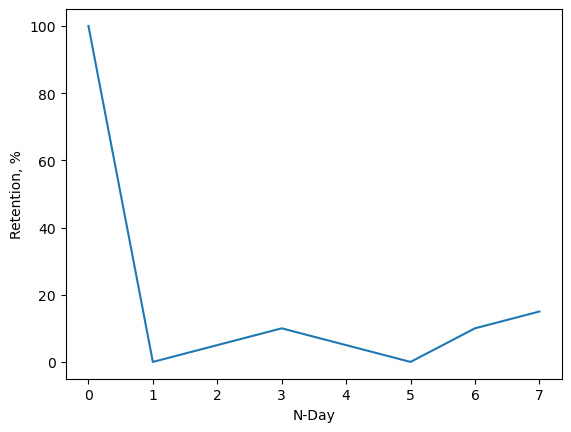

In [47]:
# Проверим работу функции 2

retention_graph(reg_path, 
                auth_path, 
                'c', 
                '2003-01-01', 
                '2003-12-31', 
                0,
                7)

In [48]:
# Функция 3, возвращающая когортный анализ 
# Retention за выбранный период

def retention_cohorts(reg_path, 
                      auth_path, 
                      r_type, 
                      min_reg, 
                      max_reg, 
                      min_nday,
                      max_nday):
    
    '''
Функция принимает следующие аргументы и параметры:
1. Пути к файлам с данными о регистрациях и авторизациях (reg_path, auth_path).
Укажите путь к файлам в двойных или одинарных кавычках.
2. Способ расчета Retention (r_type). 
Укажите в двойных или одинарных кавычках "с" для календарного способа, "w" для оконного.
3. Период регистраций (min_reg, max_reg). 
Укажите в двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд".
4. Временной отрезок Retention (min_nday, max_nday). 
Укажите минимальный и максимальный N-Day(цифры), для которых необходимо показать динамику Retention. 
    
Функция возвращает когортный анализ Retention за выбранный период.
'''
    # Загрузим 2 ДФа
    try:
        reg = pd.read_csv(reg_path, sep=';')
        auth = pd.read_csv(auth_path, sep=';')
    except:
        return print('''
Вы ввели неверный(ые) путь(и) к данным о регистрациях и авторизациях 
(reg_path, auth_path). Запустите функцию снова, указав пути к файлам 
в двойных или одинарных кавычках. Для вызова справки по функции 
введите print(retention_cohorts.__doc__).
''')
    
    # Создадим новую колонку с регистрациями в формате дат
    reg['reg_date'] = pd.to_datetime(reg.reg_ts,
                                     unit='s').dt.date
    
    # Считаем минимальную и максимальную дату регистрации
    try:
        reg_min = datetime.date(int(min_reg.split('-')[0]),
                                int(min_reg.split('-')[1]),
                                int(min_reg.split('-')[2]))
        reg_max = datetime.date(int(max_reg.split('-')[0]),
                                int(max_reg.split('-')[1]),
                                int(max_reg.split('-')[2]))
        
        if reg_min > reg_max:
            return print('''
Минимальная дата регистрации больше максимальной. Запустите функцию 
снова, указав в двойных или одинарных кавычках минимальную и 
максимальную даты регистрации для выборки в формате "гггг-мм-дд". 
Для вызова справки по функции введите print(retention_cohorts.__doc__).
''')
        
        elif reg_min > reg.reg_date.max() \
             or reg_max < reg.reg_date.min():
            return print('''
Заданный временной отрезок отсутствует в данных о регистрациях. 
Запустите функцию снова, указав в двойных или одинарных кавычках 
минимальную и максимальную даты регистрации для выборки в формате 
"гггг-мм-дд". Для вызова справки по функции введите 
print(retention_cohorts.__doc__).
''')
        
    except:
        return print('''
Вы ввели неверное(ые) значение(я) минимальной и/или максимальной
даты регистрации (min_reg, max_reg). Запустите функцию снова, указав в 
двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд". Для вызова справки по функции 
введите print(retention_cohorts.__doc__).
''')
    
    # Оставим регистрации только для выбранного периода
    reg = reg[((reg.reg_date <= reg_max) 
              & (reg.reg_date >= reg_min))] 
          
    # Объединим данные
    df = auth.merge(reg, on='uid')
    
    # Сохраним сегодняшнюю дату в переменную
    today = pd.to_datetime('today').date()  
    
    # Проверим N-Days на соответствие условиям
    try:
        if min_nday > max_nday:
            return print('''
Минимальный N-Day больше максимального. Запустите функцию 
снова, указав минимальный и максимальный N-Day(цифры), для которых 
необходимо показать динамику Retention. Для вызова справки по функции 
введите print(retention_cohorts.__doc__).
''')
        elif min_nday < 0:
            return print('''
N-Day не может быть меньше нуля. Запустите функцию снова, указав 
минимальный и максимальный N-Day(цифры), для которых необходимо 
показать динамику Retention. Для вызова справки по функции 
введите print(retention_cohorts.__doc__).
''')
        
    except:
        return print('''
Вы ввели неверное(ые) значение(я) N-Day (min_nday, max_nday). Запустите 
функцию снова, указав минимальный и максимальный N-Day(цифры), для которых 
необходимо показать динамику Retention. Для вызова справки по функции 
введите print(retention_cohorts.__doc__).
''')
        
    # В зависимости от типа расчета соберем ДФ с когортами
    # Для календарного типа расчета
    if r_type == 'c':
        
        # Создадим колонку с авторизациями в формат дате
        df['auth_date'] = pd.to_datetime(df.auth_ts,
                                    unit='s').dt.date
        
        # Создадим колонку с кол-вом прошедших дней
        df['days_passed'] = (df.auth_date - df.reg_date).dt.days       
    
    # Для оконного типа расчета
    elif r_type == 'w':
        
        # Сохраним размер окна в переменную
        secs_in_day = 24 * 60 * 60
        
        # Создадим колонку с кол-вом прошедших окон
        df['days_passed'] = (df.auth_ts - df.reg_ts) // secs_in_day
        
    else:
        return print('''
Вы ввели неверное значение способа расчета Retention (r-type). 
Запустите функцию снова, указав в двойных или одинарных кавычках "с" 
для календарного способа, "w" для оконного. Для вызова справки по функции 
введите print(retention_cohorts.__doc__).
''')   
    
    # Посчитаем, сколько пользователей вернулось на свой N-day
    df = df.groupby(['reg_date', 'days_passed'], 
                    as_index=False).uid.nunique()
        
    # Разобьем пользователей на когорты, 
    # покажем кол-во возвратов по дням
    cohorts = df.pivot(index='reg_date', 
                       columns='days_passed', 
                       values='uid') \
                .fillna(0) \
                .astype(int)
    
    # Добавим недостающие колонки с пустыми значениями
    for i in range(min_nday, max_nday + 1):
        if i not in cohorts.columns:
            cohorts[i] = [0] * len(cohorts.index)
    
    # Переведем значения в проценты,
    # отфильтруем только нужные N-Days
    cohorts = cohorts.div(cohorts[0], axis=0) \
                     .mul(100) \
                     .round(1) \
                     [list(range(min_nday, max_nday + 1))]
       
    # Для когорт, которые еще не дошли до соответствующих дней,
    # меняем 0 на пустые значения
    for i in range(len(cohorts.index)):
        for j in range(len(cohorts.columns)):
            if cohorts.index[i] \
               + pd.Timedelta(days=j) > today:
                cohorts.loc[cohorts.index[i], 
                            cohorts.columns[j]] = np.nan    
    
    # Визуализируем данные
    f, ax = plt.subplots(figsize=(11, 5))
    cg = sns.heatmap(cohorts, annot=True, cmap='Blues', fmt='g')
    cg.xaxis.tick_top()
    cg.set(xlabel=None, ylabel=None)
    plt.yticks(rotation=0)
    cg.text(0, 0, '')
        
    # Вернем когортный анализ
    return cg

<AxesSubplot:>

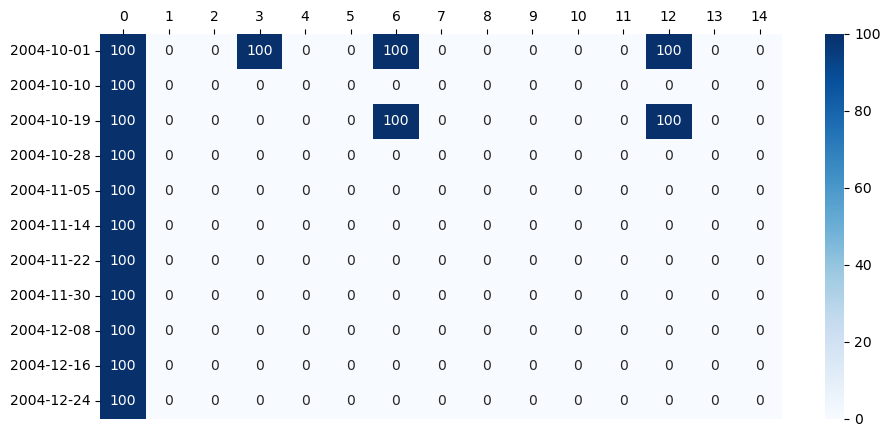

In [49]:
# Проверим работу функции 3

retention_cohorts(reg_path, 
                  auth_path, 
                  'c', 
                  '2004-10-01', 
                  '2004-12-31', 
                  0,
                  14)

# Анализ результатов A/B тестирования.

In [50]:
# Присвоим переменной адрес с данными

ab_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [51]:
# Считаем данные в ДФ

ab_df = pd.read_csv(ab_path, sep=';')

In [52]:
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [53]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [54]:
# Посмотрим, все ли записи уникальные

ab_df.user_id.nunique()

404770

In [55]:
# Узнаем, сколько у нас групп

ab_df.testgroup.nunique()

2

Проанализируем результаты по следующему алгоритму:
1. Сравним ARPU, т.к. это важная и комплексная продуктовая метрика.
2. Сравним ARPPU и CR. Именно из них складывается ARPU, но может сложиться такая ситуция, что ARPU не покажет стат. значимых отличий, а одна из этих метрик покажет, кроме того, зная 2 этих метрики у нас будет понимание, что именно влияет на доход.
3. Посмотрим на распределения каждой из метрик.
4. Подберем группы возможных статистических тестов.
5. Просимулируем, чтобы понять, какие тесты лучше подходят.
6. Проведем тесты.
7. Подведем итоги.

In [56]:
# Посчитаем ARPU для каждой из групп

a_arpu = ab_df[ab_df.testgroup == 'a'].revenue.mean()
b_arpu = ab_df[ab_df.testgroup == 'b'].revenue.mean()

In [57]:
round(a_arpu, 1)

25.4

In [58]:
round(b_arpu, 1)

26.8

In [59]:
# Сравним ARPU
round((b_arpu / a_arpu) * 100 - 100, 1)

5.3

ARPU в группе А - 25.4, в группе B - 26.8.
ARPU в группе B выше, чем в группе A на 5.3%.

In [60]:
# Сохраним группы покупателей в переменные

dist_a = ab_df[(ab_df.testgroup == 'a')
               & (ab_df.revenue > 0)]
dist_b = ab_df[(ab_df.testgroup == 'b')
               & (ab_df.revenue > 0)]

<AxesSubplot:xlabel='revenue', ylabel='Count'>

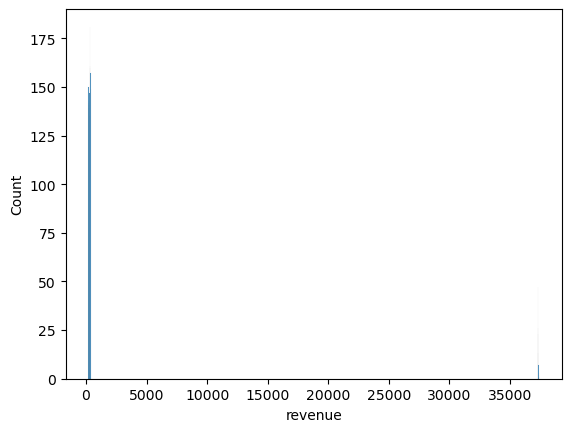

In [61]:
# Посмотрим на распределения для ARPPU
# в группе А

sns.histplot(dist_a.revenue)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

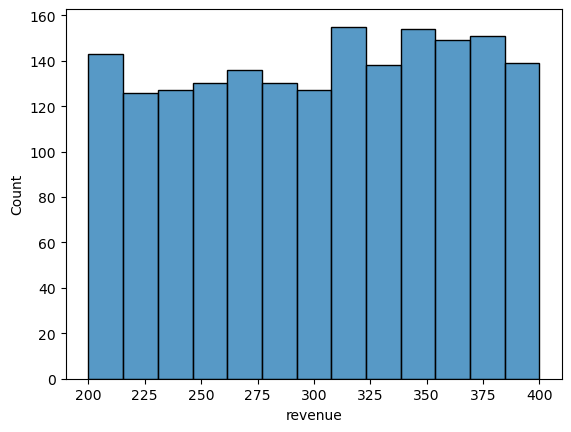

In [62]:
# Посмотрим на группу А без выбросов

sns.histplot(ab_df[(ab_df.testgroup == 'a')
                   & (ab_df.revenue > 0)
                   & (ab_df.revenue < 35000)].revenue)

In [63]:
# Посмотрим на кол-во значений без выбросов

ab_df[(ab_df.testgroup == 'a')
      & (ab_df.revenue > 0)
      & (ab_df.revenue < 35000)].shape[0]

1805

In [64]:
# Посмотрим на кол-во выбросов

ab_df[(ab_df.testgroup == 'a')
      & (ab_df.revenue > 35000)].shape[0]

123

<AxesSubplot:xlabel='revenue', ylabel='Count'>

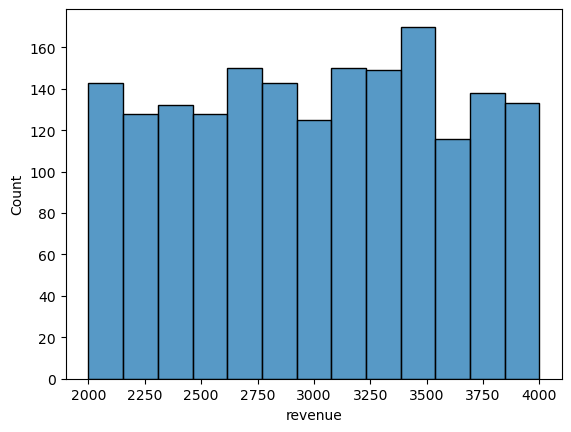

In [65]:
# в группе B

sns.histplot(dist_b.revenue)

In [66]:
# Посмотрим на кол-во значений в группе B

dist_b.shape[0]

1805

В идеале, нужно было бы посмотреть на группу с выбросами, чтобы понять, это ошибка, фрод, совпадение или действительно есть какая-то логика, которая вписывает ее в общую картину.

В данной ситуации можно работать разными способами, среди них выделю 3 варианта:
1. Убрать их, оставив только основную группу.
2. Работать не со средним в качестве меры центральной тенденции, а с медианой, которая нивелирует эффект Билла Гейтса.
3. Работать с тем, что есть, и считать классические метрики.

### Вариант 1.

Аргументы:
1. Группа выбросов составляет менее 7% от общего кол-ва наблюдений, при этом значения в ней превышают среднее 1й группы более, чем в 100 раз. Это небольшая часть общей выборки, вызывающая эффект Билла Гейтса своим присутствием.
2. Распределения в левой части группы А и в группе B похожи на равномерные, а не вытянутые направо длиннохвостовые. Значения не растянуты, они стоят отдельной группой, т.е. группа А состоит из 2х очевидных кластеров, поэтому здесь скорее мы говорим об аномалии, чем об особенностях распределения, но точно это утверждать не можем.

In [67]:
# Сохраним группу А без выбросов

dist_ac = ab_df[(ab_df.testgroup == 'a')
                & (ab_df.revenue > 0)
                & (ab_df.revenue < 35000)]

In [68]:
# Посчитаем ARPPU
# для группы А без выросов

arppu_a = round(dist_ac.revenue.mean(), 1)

In [69]:
arppu_a

302.5

In [70]:
# ARPPU группы B

arppu_b = round(dist_b.revenue.mean(), 1)

In [71]:
arppu_b

3003.7

Для сравнения средних по умолчанию мы выбираем Т-тест.

Споры относительно требований к нему не утихают до сих пор, поэтому попробуем удовлетворить обе позиции: проверим, выполняются ли требования, тк возможно, они выполняются, кроме того, проведем симуляции, чтобы определить мощность и тенденцию к ошибке 1го рода. 

Если же результаты проверки качества нас не удовлетворят, можно будет рассмотреть альтернативные варианты - непараметрический аналог - U-тест Манна-Уитни и Bootstrap.

Встречаются 3 основных требования для проведения Т-Теста:
1. Равенство выборок. Мы будем проводить Т-тест Уэлча, который нечувствителен к этому параметру.
2. Гомоскедастичность, т.е. равенство дисперсий в 2х группах. Для проверки проводится тест Левена, но Т-тест Уэлча хорошо работает и при наличии гомоскедастичности, и при ее отсутствии.
3. Нормальность распределений. Проведем тесты Шапиро-Уилка и Д'Агустино-Пирсона, построим QQ-plot'ы.

In [72]:
# Тест Шапиро-Уилка
ss.shapiro(dist_ac.revenue)

ShapiroResult(statistic=0.9546271562576294, pvalue=3.002848260644267e-23)

In [73]:
# Тест Д'Агустино-Пирсона

ss.normaltest(dist_ac.revenue)

NormaltestResult(statistic=1341.2009917493335, pvalue=5.779697118077758e-292)

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

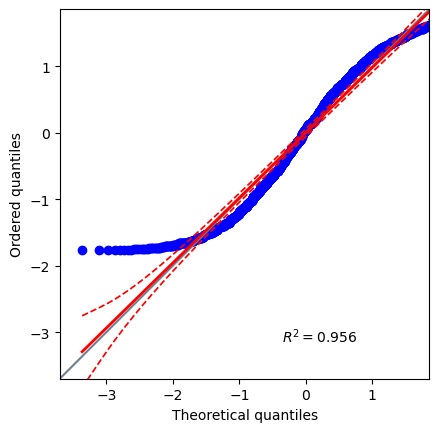

In [74]:
# QQ-plot

pg.qqplot(dist_ac.revenue)

Оба теста при p-value < 0.05 позволяют нам отклонить нулевую гипотезу о том, что распределение нормальное, а qq-plot демонстрирует то, что наш график по большей части находится за рамками 95% доверительного интервала нормального распределения. 

Интересно, что коэффициент детерминации, т.е. корреляция в квадрате, находится на очень высоком уровне, демонстрируя одну из ситуаций, когда она не работает и причину, почему всегда лучше смотреть не только на цифры, но и на график.

Посмотрим на 2е распределение.

In [75]:
# Тест Шапиро-Уилка
ss.shapiro(dist_b.revenue)

ShapiroResult(statistic=0.9583134651184082, pvalue=2.4929213770979496e-22)

In [76]:
# Тест Д'Агустино-Пирсона

ss.normaltest(dist_b.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

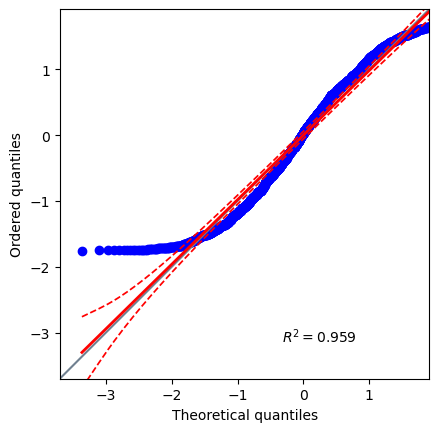

In [77]:
# QQ-plot

pg.qqplot(dist_b.revenue)

У распределения в группе B аналогичная картина.

Поскольку требования к проведению Т-теста не выполняются, проверим мощность теста и тенденцию к ошибкам 1го рода.

In [78]:
# Рассчитаем d Коэна

d = (dist_b.revenue.mean() - dist_ac.revenue.mean()) / \
    np.sqrt((np.std(dist_b.revenue) ** 2 + np.std(dist_ac.revenue) ** 2) / 2)

In [79]:
# Проверяем мощность

pg.power_ttest2n(dist_ac.shape[0], 
                 dist_b.shape[0], 
                 d=d, 
                 alpha=0.05)

1.0

In [80]:
# Посчитаем разницу между средними для симуляции

diff = dist_b.revenue.mean() - dist_ac.revenue.mean()

In [81]:
# Вычтем разницу из группы B, чтобы уравнять средние

db_equal = dist_b.revenue - diff

In [82]:
# Проведем симуляцию, чтобы определить тенденцию
# к ошибкам 1го рода

# Зададим кол-во симуляций
n_tt = 1000

# Создадим список для сбора результатов
results_tt = []

# Напишем цикл
for _ in tqdm(range(n_tt)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = dist_ac.revenue.value_counts(normalize=True) \
                          .reset_index() 
    vc_b = db_equal.value_counts(normalize=True) \
                   .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_ac))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    ttest = ss.ttest_ind(dal, dbl, equal_var=False)[1] < 0.05
    
    # Добавим итог в список
    results_tt.append(ttest)
    
# Выведем процент ошибок 1го рода
print(sum(results_tt) / n_tt)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.22it/s]

0.06


Как мы видим из симуляций, Т-тест, несмотря на несоответствие распределений требованиям о нормальности, демонстрирует отличную мощность и допустимый процент ошибок 1го рода.

Проведем тест с нашими данными.

In [83]:
ss.ttest_ind(dist_ac.revenue, dist_b.revenue, equal_var=False)

Ttest_indResult(statistic=-199.3972253399533, pvalue=0.0)

При p-value < 0.05 мы отвергаем нулевую гипотезу и принимаем альтернативную, т.е. признаем разницу между средними 2х групп статистически значимой.

Поскольку мы убрали выбросы группы А при расчете ARPPU, то будет логично убрать их и при расчете конверсии по тем же причинам.

Для сравнения кол-ва покупателей в обеих группах посчитаем критерий Хи-квадрат Пирсона таблицы соряженности.

In [84]:
# Уберем выбросы из данных

df_filtered = ab_df[ab_df.revenue < 35000].copy()

In [85]:
# Создадим колонку с оплатами

df_filtered['paying'] = df_filtered.revenue > 0

In [86]:
# Соберем таблицу сопряженности

ab_ct = pd.crosstab(df_filtered.testgroup,
                    df_filtered.paying)

In [87]:
ab_ct

paying,False,True
testgroup,,
a,200175,1805
b,200862,1805


In [88]:
# Проведем тест

ss.chi2_contingency(ab_ct)[1]

0.9316668591658103

In [89]:
# Мощность Хи-квадрат

# Зададим вероятности для распределений
a_prob = df_filtered[df_filtered.testgroup == 'a'].paying.mean()
b_prob = df_filtered[df_filtered.testgroup == 'b'].paying.mean()

# Зададим размеры выборок
a_len = len(df_filtered[df_filtered.testgroup == 'a'])
b_len = len(df_filtered[df_filtered.testgroup == 'b'])

# Зададим кол-во итераций цикла
n_chi = 1000

# Создадим список с результатами
results_chi = []

for _ in tqdm(range(n_chi)):
    
    # Сгенерируем распределения
    a = np.random.binomial(1, a_prob, a_len)
    b = np.random.binomial(1, b_prob, b_len)
    
    # Создадим колонки с подписями
    a_sign = ['a'] * a_len
    b_sign = ['b'] * b_len
    
    # Соберем ДФы
    df_a = pd.DataFrame({'group': a_sign,
                         'paying': a})
    df_b = pd.DataFrame({'group': b_sign,
                         'paying': b})
    
    # Объединим ДФы
    df = pd.concat([df_a, df_b])
    
    # Соберем таблицу сопряженности
    ct = pd.crosstab(df.group, df.paying)
    
    # Проведем тест
    result = ss.chi2_contingency(ct)[1] < 0.05
    
    # Запишем результат в список
    results_chi.append(result)
    
# Выведем мощность
print(sum(results_chi) / n_chi)    

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:48<00:00,  5.95it/s]

0.035


При p-value > 0.05 нас нет оснований отклонить нулевую гипотезу об обсутствии отличий между фактическими данными и ождиаемыми. При этом мощность теста находится на очень низком уровне, т.е. вероятность задетектировать различия такого размера в этой ситуации близится к нулю.

Посмотрим на альтернативу - точный тест Фишера.

In [90]:
# Проведем тест

ss.fisher_exact(ab_ct)[1]

0.920108418523283

In [91]:
# Мощность теста Фишера

# Зададим кол-во итераций цикла
n_ft = 1000

# Создадим список с результатами
results_fisher = []

for _ in tqdm(range(n_ft)):
    
    # Сгенерируем распределения
    a = np.random.binomial(1, a_prob, a_len)
    b = np.random.binomial(1, b_prob, b_len)
    
    # Создадим колонки с подписями
    a_sign = ['a'] * a_len
    b_sign = ['b'] * b_len
    
    # Соберем ДФы
    df_a = pd.DataFrame({'group': a_sign,
                         'paying': a})
    df_b = pd.DataFrame({'group': b_sign,
                         'paying': b})
    
    # Объединим ДФы
    df = pd.concat([df_a, df_b])
    
    # Соберем таблицу сопряженности
    ct = pd.crosstab(df.group, df.paying)
    
    # Проведем тест
    result = ss.fisher_exact(ct)[1] < 0.05
    
    # Запишем результат в список
    results_fisher.append(result)
    
# Выведем мощность
print(sum(results_fisher) / n_ft) 

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:57<00:00,  5.65it/s]

0.047


С тестом Фишера картина аналогичная.

На примере Хи-Квадрат посмотрим, какой размер выборки поможет задетектировать эффект такого размера с приемлемым уровнем мощности.

In [92]:
# Заведем переменную для проверки
power = 0

# Заведем списки для графика
powers = []
lens = []

# Проверка перед каждой итерацией
while power < 0.8 \
      and a_len < 10000000:

    # Создадим список с результатами
    results_chi = []

    # Запустим цикл
    for _ in tqdm(range(10)):

        # Сгенерируем распределения
        a = np.random.binomial(1, a_prob, a_len)
        b = np.random.binomial(1, b_prob, b_len)

        # Создадим колонки с подписями
        a_sign = ['a'] * a_len
        b_sign = ['b'] * b_len

        # Соберем ДФы
        df_a = pd.DataFrame({'group': a_sign,
                             'paying': a})
        df_b = pd.DataFrame({'group': b_sign,
                             'paying': b})

        # Объединим ДФы
        df = pd.concat([df_a, df_b])

        # Соберем таблицу сопряженности
        ct = pd.crosstab(df.group, df.paying)

        # Проведем тест
        result = ss.chi2_contingency(ct)[1] < 0.05

        # Запишем результат в список
        results_chi.append(result)

    # Посчитаем мощность
    power = sum(results_chi) / 10
    
    # Выводим после каждой итерации мощность 
    # и размер выборки
    print(power, a_len)
    
    # Сохраняем их в список для визуализации
    powers.append(power)
    lens.append(a_len)
    
    # Увеличим размер выборки
    # для следующей итерации
    a_len *= 2
    b_len *= 2

100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.87it/s]


0.0 201980


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.48it/s]


0.2 403960


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]


0.1 807920


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]


0.0 1615840


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.82s/it]


0.0 3231680


100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.06s/it]

0.0 6463360


Даже при миллионных выборках мощность теста остается на неприемлемом уровне, очевидно, что настолько небольшой эффект в реальных условиях зафиксировать практически невозможно.

Смысла в визуализации в данной ситуации нет.

\**Все симуляции нужно проводить хотя бы с 1000 итераций, а лучше с 10000, но в данном случае мы преследовали цель показать наличие такой возможности и ход мысли. В дальнейшем, с целью экономии ресурсов, мы также будем сокращать количество итераций в некоторых симуляциях, помня о том, что в рабочих условиях есть определенные требования.*

### Вариант 1. Итог.

ARPPU у группы B выше и статистически значимо отличается от группы А.

Конверсия в покупателя находится в обеих группах примерно на одном уровне, зафиксировать статистически значимые различия, даже если они присутствуют, при такой разнице практически невозможно.

Как следствие, ARPU в группе B также выше.

Набор акционных предложений для группы B показал себя лучше.

### Вариант 2.
Аргументы те же, что и в 1м варианте, но другой подход к работе с распределениями.

В этом варианте мы будем работать не со средним в качестве меры центральной тенденции, а с медианой, т.к. есть выбросы, т.е. вычислять будем не классический ARPPU, т.к. там используется среднее арифметическое, а несколько измененный.

Сравнивать медианы будем с помощью Bootstrap.

In [93]:
# Вычислим медианы для 2х групп

median_a = dist_a.revenue.median()
median_b = dist_b.revenue.median()

In [94]:
median_a

311.0

In [95]:
median_b

3022.0

In [96]:
# Bootstrap

pg.compute_bootci(dist_b.revenue, 
                  dist_a.revenue, 
                  n_boot=10000, 
                  func=lambda x, y: np.median(x) - np.median(y))

array([2656., 2760.])

In [97]:
# Посчитаем разницу между медианами для симуляции

diff_bs = dist_b.revenue.median() - dist_a.revenue.median()

In [98]:
# Вычтем разницу из группы B, чтобы уравнять средние

db_equal_bs = dist_b.revenue - diff_bs

In [99]:
# Тенденция Bootstrap совершать ошибки 1го рода

# Зададим кол-во симуляций
n_bs = 100

# Создадим список для сбора результатов
results_bs = []

# Напишем цикл
for _ in tqdm(range(n_bs)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = dist_a.revenue.value_counts(normalize=True) \
                         .reset_index() 
    vc_b = db_equal_bs.value_counts(normalize=True) \
                      .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_a))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    bs = pg.compute_bootci(dal, 
                           dbl, 
                           n_boot=10000, 
                           func=lambda x, y: np.median(x) - np.median(y)) 
    
    # Сохраним результат
    result = np.sign(bs[0]) == np.sign(bs[1])
    
    # Добавим результат в список
    results_bs.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_bs) / n_bs)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:49<00:00,  4.10s/it]

0.08


Доверительный интервал разницы медиан 2х групп сильно смещен и не пересекается с нулем, процент ошибок 1го рода низкий, а это значит, что у нас есть все основания полагать, что медианы отличаются статистически значимо, т.е. вывод, сделанный в 1м варианте подтверждается и во втором.

Посмотрим на конверсию.

In [100]:
# Создадим колонку с оплатами

ab_df['paying'] = ab_df.revenue > 0

In [101]:
# Посмотрим на конверсию
# в группе А

round((sum(ab_df[ab_df.testgroup == 'a'].paying) \
        / len(ab_df[ab_df.testgroup == 'a'])) * 100, 2)

0.95

In [102]:
# в группе B

round((sum(ab_df[ab_df.testgroup == 'b'].paying) \
        / len(ab_df[ab_df.testgroup == 'b'])) * 100, 2)

0.89

In [103]:
# Соберем таблицу сопряженности

full_ct = pd.crosstab(ab_df.testgroup,
                      ab_df.paying)

In [104]:
# Проведем тест

ss.chi2_contingency(full_ct)[1]

0.03647561892312613

In [105]:
# Тенденция Хи-квадрат совершать ошибки 1го рода

# Зададим вероятность для распределений
ap = ab_df[ab_df.testgroup == 'a'].paying.mean()

# Зададим размеры выборок
al = len(ab_df[ab_df.testgroup == 'a'])
bl = len(ab_df[ab_df.testgroup == 'b'])

# Зададим кол-во итераций цикла
n_chi_c = 1000

# Создадим список с результатами
results_chi_c = []

for _ in tqdm(range(n_chi_c)):
    
    # Сгенерируем распределения c одинаковой вероятностью
    a = np.random.binomial(1, ap, al)
    b = np.random.binomial(1, ap, bl)
    
    # Создадим колонки с подписями
    a_sign = ['a'] * al
    b_sign = ['b'] * bl
    
    # Соберем ДФы
    df_a = pd.DataFrame({'group': a_sign,
                         'paying': a})
    df_b = pd.DataFrame({'group': b_sign,
                         'paying': b})
    
    # Объединим ДФы
    df = pd.concat([df_a, df_b])
    
    # Соберем таблицу сопряженности
    ct = pd.crosstab(df.group, df.paying)
    
    # Проведем тест
    result = ss.chi2_contingency(ct)[1] < 0.05
    
    # Запишем результат в список
    results_chi_c.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_chi_c) / n_chi_c) 

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:59<00:00,  5.56it/s]

0.046


При p-value < 0.05 и приемлемом уровне процента ошибок 1го рода у нас есть все основания, чтобы отвергнуть нулевую гипотезу и принять альтернативную - значения в таблице сопряженности статистически значимо отличаются от ожидаемых.

### Вариант 2. Итог.
Поскольку группа А демонстрирует более высокую конверсию, а группа B - более высокий ARPPU(медиану), для того, чтобы решить, какой набор лучше, необходимо посмотреть на результирующую, т.е. на ARPU(также медиану), но большинство значений revenue в наших группах это 0, поэтому обе медианы будут равны 0. 

В такой ситуации можно ориентироваться на нашу юнит-экономику: делать выбор, исходя из того, как изменения той или иной метрики влияет на нашу прибыль, какая из них важнее, но с этим набором данных в этом варианте однозначный вывод сделать нельзя.

### Вариант 3.

Есть вероятность, что именно в такой разнице между предложениями и заключался эксперимент. На примере коллекционной карточной игры:
1. Первой группе дали возможность делать точечные покупки, приобретать отдельные карты за очень небольшую плату, а также вариант купить всю коллекцию за значительную сумму.
2. Продают паки с картами примерно по одной цене.

В такой ситуации выбросы с точки зрения статистики, вероятно, нельзя назвать выбросами, это скорее небольшая спрогнозированная группа крупных покупателей и срезать их медианой, а тем более удалять из данных - будет неправильно, т.к. мы хотим понять, сколько в итоге заработаем с учетом именно такого большого разрыва в предложениях.

Для этого варианта посчитаем ARPPU со средними арифметическими.

In [106]:
# Посчитаем ARPPU

dist_a.revenue.mean()

2663.9984439834025

In [107]:
dist_b.revenue.mean()

3003.6581717451522

Проверим качество Т-теста.

In [108]:
# Рассчитаем d Коэна

d2 = (dist_b.revenue.mean() - dist_a.revenue.mean()) / \
     np.sqrt((np.std(dist_b.revenue) ** 2 + np.std(dist_a.revenue) ** 2) / 2)

In [109]:
# Проверяем мощность

pg.power_ttest2n(dist_a.shape[0], 
                 dist_b.shape[0], 
                 d=d2, 
                 alpha=0.05)

0.3661862179309084

Здесь, в отличие от 1го варианта, разница между средними значительно ниже, а в распределение А добавились выбросы, что в сопокупности сильно понизило мощность теста. Посмотрим на непараметрику - U-тест Манна-Уитни.

In [110]:
# Мощность U-теста

# Зададим кол-во симуляций
n_mw = 1000

# Создадим список для сбора результатов
results_mw = []

# Напишем цикл
for _ in tqdm(range(n_mw)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = dist_a.revenue.value_counts(normalize=True) \
                         .reset_index() 
    vc_b = dist_b.revenue.value_counts(normalize=True) \
                         .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_a))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    result = ss.mannwhitneyu(dal, dbl)[1] < 0.05
    
    # Добавим результат в список
    results_mw.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_mw) / n_mw)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.99it/s]

1.0


In [111]:
# Посчитаем разницу между средними для симуляции

diff_mw = dist_b.revenue.mean() - dist_a.revenue.mean()

In [112]:
# Вычтем разницу из группы B, чтобы уравнять средние

db_equal_mw = dist_b.revenue - diff_mw

In [113]:
# Тенденция к ошибкам 1го рода

# Зададим кол-во симуляций
n_mw2 = 1000

# Создадим список для сбора результатов
results_mw2 = []

# Напишем цикл
for _ in tqdm(range(n_mw2)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = dist_a.revenue.value_counts(normalize=True) \
                         .reset_index() 
    vc_b = db_equal_mw.value_counts(normalize=True) \
                      .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_a))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    result = ss.mannwhitneyu(dal, dbl)[1] < 0.05
    
    # Добавим результат в список
    results_mw2.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_mw2) / n_mw2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.29it/s]

1.0


Тест Манна-Уитни детектирует различия почти всегда, даже если их нет, поэтому это тоже плохой вариант.

Посмотрим на Bootstrap.

In [114]:
# Мощность Bootstrap

# Зададим кол-во симуляций
n_bs2 = 100

# Создадим список для сбора результатов
results_bs2 = []

# Напишем цикл
for _ in tqdm(range(n_bs2)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = dist_a.revenue.value_counts(normalize=True) \
                         .reset_index() 
    vc_b = dist_b.revenue.value_counts(normalize=True) \
                         .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_a))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    bs = pg.compute_bootci(dal, 
                           dbl, 
                           n_boot=10000, 
                           func=lambda x, y: np.mean(x) - np.mean(y)) 
    
    # Сохраним результат
    result = np.sign(bs[0]) == np.sign(bs[1])
    
    # Добавим результат в список
    results_bs2.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_bs2) / n_bs2)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.97s/it]

0.33


In [115]:
# Тенденция Bootstrap ошибаться

# Зададим кол-во симуляций
n_bs3 = 100

# Создадим список для сбора результатов
results_bs3 = []

# Напишем цикл
for _ in tqdm(range(n_bs3)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = dist_a.revenue.value_counts(normalize=True) \
                         .reset_index() 
    vc_b = db_equal_mw.value_counts(normalize=True) \
                      .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_a))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    bs = pg.compute_bootci(dal, 
                           dbl, 
                           n_boot=10000, 
                           func=lambda x, y: np.mean(x) - np.mean(y)) 
    
    # Сохраним результат
    result = np.sign(bs[0]) == np.sign(bs[1])
    
    # Добавим результат в список
    results_bs3.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_bs3) / n_bs3)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]

0.07


Bootstrap также показывает низкую мощность, при этом ошибается с приемлемой частотой. Если он или Т-тест покажет разницу между средними, можно быть уверенными, что она есть с высокой долей вероятности, если же не покажет, это может быть как нехватка мощности, так и отсутствие статистически значимых отличий.

In [116]:
pg.compute_bootci(dist_a.revenue, 
                  dist_b.revenue, 
                  n_boot=10000, 
                  func=lambda x, y: np.mean(x) - np.mean(y))

array([-742.33,   63.97])

0 входит в наш диапазон, а это значит, что у нас нет оснований отклонить нулевую гипотезу и признать отличия между средними статистически значимыми.

Посмотрим, как поведут себя тесты с ARPU, там выборки значительно больше, поэтому возможно и тесты будут работать лучше.
Начнем с Т-теста.

In [117]:
# Сохраним группы в переменные

ga = ab_df[ab_df.testgroup == 'a'].revenue
gb = ab_df[ab_df.testgroup == 'b'].revenue

In [118]:
# Рассчитаем d Коэна

d3 = (gb.mean() - ga.mean()) / \
     np.sqrt((np.std(gb) ** 2 + np.std(ga) ** 2) / 2)

In [119]:
# Проверяем мощность

pg.power_ttest2n(ga.shape[0], 
                 gb.shape[0], 
                 d=d3, 
                 alpha=0.05)

0.09564097379603402

У Т-теста результаты еще хуже. У Манна-Уитни вероятно будут тоже, т.к. подавляющее большинство значений в группах - это нули.

In [120]:
# Посчитаем разницу распределений

diff_4 = gb.mean() - ga.mean()

In [121]:
# Сместим B для симуляции

gb_equal = gb - diff_4

In [122]:
# Тенденция к ошибкам 1го рода

# Зададим кол-во симуляций
n_mw3 = 1000

# Создадим список для сбора результатов
results_mw3 = []

# Напишем цикл
for _ in tqdm(range(n_mw3)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = ga.value_counts(normalize=True) \
             .reset_index() 
    vc_b = gb_equal.value_counts(normalize=True) \
                   .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(ga))
    dbl = db.rvs(size=len(gb))
    
    # Проведем тест
    result = ss.mannwhitneyu(dal, dbl)[1] < 0.05
    
    # Добавим результат в список
    results_mw3.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_mw3) / n_mw3)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:21<00:00,  1.22s/it]

1.0


Мы оказались правы. Посмотрим на Bootstrap.

In [123]:
# Мощность Bootstrap

# Зададим кол-во симуляций
n_bs3 = 100

# Создадим список для сбора результатов
results_bs3 = []

# Напишем цикл
for _ in tqdm(range(n_bs3)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = ga.value_counts(normalize=True) \
             .reset_index() 
    vc_b = gb.value_counts(normalize=True) \
             .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=10000)
    dbl = db.rvs(size=10000)
    
    # Проведем тест
    bs = pg.compute_bootci(dal, 
                           dbl, 
                           n_boot=10000, 
                           func=lambda x, y: np.mean(x) - np.mean(y)) 
    
    # Сохраним результат
    result = np.sign(bs[0]) == np.sign(bs[1])
    
    # Добавим результат в список
    results_bs3.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_bs3) / n_bs3)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:01<00:00, 10.22s/it]

0.08


Bootstrap демонстрирует низкую мощность.

С ARPU тесты ведут себя еще хуже, чем с ARPPU.

Попробуем прологарифмировать наши распределения, чтобы повысить эффективность Т-теста.

In [124]:
# Сохраним прологарифмированные распределения

lda = np.log(dist_a.revenue)
ldb = np.log(dist_b.revenue)

In [125]:
# Рассчитаем d Коэна

d4 = (ldb.mean() - lda.mean()) / \
     np.sqrt((np.std(ldb) ** 2 + np.std(lda) ** 2) / 2)

In [126]:
# Проверяем мощность

pg.power_ttest2n(dist_a.shape[0], 
                 dist_b.shape[0], 
                 d=d4, 
                 alpha=0.05)

1.0

In [127]:
# Посчитаем разницу распределений

diff_5 = ldb.mean() - lda.mean()

In [128]:
# Сместим B для симуляции

ldb_equal = ldb - diff_5

In [129]:
# Ошибки 1го рода

# Тенденция к ошибкам 1го рода

# Зададим кол-во симуляций
n_tt2 = 1000

# Создадим список для сбора результатов
results_tt2 = []

# Напишем цикл
for _ in tqdm(range(n_tt2)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = lda.value_counts(normalize=True) \
              .reset_index() 
    vc_b = ldb_equal.value_counts(normalize=True) \
                    .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(dist_a))
    dbl = db.rvs(size=len(dist_b))
    
    # Проведем тест
    result = ss.ttest_ind(dal, dbl, equal_var=False)[1] < 0.05
    
    # Добавим результат в список
    results_tt2.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_tt2) / n_tt2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]

0.057


Логарифмирование ожидаемо помогло. Причем настолько, что и мощность, и процент ошибок 1го рода вышли на приемлемый уровень.

Проведем тест для логарифмов доходов на платящего клиента.

In [130]:
# Т-тест Уэлча логарифмов 

ss.ttest_ind(lda, ldb, equal_var=False)[1]

0.0

При p-value < 0.05 мы отклоняем нулевую гипотезу и принимаем альтернативную о том, что логарифмы доходов на платящего клиента статистически значимо отличаются.

Мы вновь приходим к точке, как во 2м варианте, у нас лучше конверсия в группе А и выше ARPPU в группе B. Чтобы сделать выбор, посмотрим на прологарифмированную результирующую ARPU.

In [131]:
# Сохраним прологарифмированные распределения,
# прибавив единицу, тк логарифм 0 это -inf

lga = np.log(ga + 1)
lgb = np.log(gb + 1)

In [132]:
# рассчитаем d Коэна

d5 = (lgb.mean() - lga.mean()) / \
     np.sqrt((np.std(lgb) ** 2 + np.std(lga) ** 2) / 2)

In [133]:
# Проверяем мощность

pg.power_ttest2n(ga.shape[0], 
                 gb.shape[0], 
                 d=d5, 
                 alpha=0.05)

1.0

In [134]:
# Посчитаем разницу распределений

diff_6 = lgb.mean() - lga.mean()

In [135]:
# Сместим B для симуляции

lgb_equal = lgb - diff_6

In [136]:
# Ошибки 1го рода

# Тенденция к ошибкам 1го рода

# Зададим кол-во симуляций
n_tt3 = 1000

# Создадим список для сбора результатов
results_tt3 = []

# Напишем цикл
for _ in tqdm(range(n_tt3)):
    
    # Сгенерируем распределения
    # Соберем значения и их частоту
    vc_a = lga.value_counts(normalize=True) \
              .reset_index() 
    vc_b = lgb_equal.value_counts(normalize=True) \
                    .reset_index()     
    
    # Сформируем списки со значениями и частотами
    va = vc_a['index'].to_list()
    vb = vc_b['index'].to_list()
    fa = vc_a.revenue.to_list()
    fb = vc_b.revenue.to_list()
    
    # Создадим распределения
    da = ss.rv_discrete(name='da', values=(va, fa))
    db = ss.rv_discrete(name='db', values=(vb, fb))
    
    # Сгенерируем распредения
    dal = da.rvs(size=len(ga))
    dbl = db.rvs(size=len(gb))
    
    # Проведем тест
    result = ss.ttest_ind(dal, dbl, equal_var=False)[1] < 0.05
    
    # Добавим результат в список
    results_tt3.append(result)
    
# Выведем процент ошибок 1го рода
print(sum(results_tt3) / n_tt3)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:25<00:00,  1.08it/s]

0.05


Мощность и процент ошибок 1го рода на допустимых уровнях, значит можно проводить Т-тест.

In [137]:
# Т-тест Уэлча логарифмов 

ss.ttest_ind(lga, lgb, equal_var=False)[1]

7.314671415006434e-11

При p-value < 0.05 мы отвергаем нулевую гипотезу о равенстве средних логарифмов доходов на клиента и принимаем альтернативную о статистически значимых отличиях между ними.

### Вариант 3. Итог.
Группа А демонстрирует более высокую конверсию, группа B - более высокий ARPPU. 

Как суммирующая метрика, ARPU демонстрирует, что группа B лучше, чем группа А.

# Метрики для оценки тематического события.

1. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

2. Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Метрики 1го варианта.

1. **Относительное кол-во активных пользователей.** Делим кол-во активных игроков каждого дня события на среднее кол-во активных игроков в тот же день недели за предшествующий период за рамками событий. Получаем дополнительную долю игроков, привлеченных, возможно, за счет события. Можно поиграть с сезонностью, например, смотреть не дни недели, а 2 группы: будние и выходные с праздниками, в зависимости от нашей сезонности.
- Смотрим, как метрика меняется в течение события.
- Сравниваем средний приток текущего события и предыдущего за весь период.
- Можно сравнить средние притоки первых дней для последних 2х событий. Если сейчас приток выше, значит, возможно, последнее событие понравилось и люди пришли на новое, если же нет, то прошлое скорее не понравилось и новое ажиотажа не вызывает.

2. Аналогичные показатели и сравнения для **среднего времени, проведенного в игре в день** (кроме последнего пункта, т.к. для этой метрики его логика не работает).

3. **Retention.**
- За период проведения события и в течение первой недели после, считать по дням, за нулевой считать 1й вход внутри события для всех пользователей, а не только для новых. Сравнить с аналогичным показателем предыдущих событий.
- Сравнить отношение классического Retention 1го дня за период проведения события к среднему за период предшествующий событию. Получим прирост Retention, возможно, за счет события.

4. **ARPPU.** 
- Внутри события по дням. Если событие выстроено по принципу от простых заданий к сложным это особенно актуально. Считаем метрику по дням недели или группам дней в рамках события и считаем отношение к аналогичному показателю за период предшествующий событию. Можно посчитать также соотношение этих 2х значений и сравнить с аналогичным соотношением предыдущего события.
- Для более общего понимания - сравнить средние ARPPU за период предшествующий и период события.

5. **Конверсия в покупку** (доля пользователей, зашедших в приложение в заданный период, совершивших покупку). Считаем аналогичные ARPPU варианты.

6. Все то же самое для **ARPU**, как для результирующей метрики.

7. Сравнить **средние оценки**, выставляемые в **Google Play и App Store** во время проведения события, с предшествующим периодом.

8. Можно предложить за небольшую дополнительную награду пройти опрос и собрать дополнительную информацию, например, составить **рейтинг удовлетворенности** или что-то подобное, чтобы сравнить его с предыдущим событием.

9. Если мы продаем **пропуск события**, то посчитать процент купивших его среди тех, кто заходил в игру в течение первых дней события (чтобы понять скольки дней, нужно знать, как долго идет событие, какая у него структура и проч.), т.к. ближе к концу события пропуск не будут покупать просто потому, что не смогут его реализовать. Если же за покупку пропуска выдаются эксклюзивные награды, то этим можно принебречь и считать процент за весь период. Метрику сравниваем с предыдущими событиями.

10. **Средний процент пользователей, которые берутся за выполнение заданий, из общего числа активных юзеров дня за весь период события**. Сравнить процент с прошлыми событиями. Метрика показывает, насколько вообще событие интересно и насколько привлекательными являются награды.

11. Среди пользователей события - **какой процент совершает внутриигровые покупки**. Сравнить процент с прошлыми событиями. Метрика показывает, насколько мы стимулируем покупки наградами и сложностью заданий.

12. **Какой процент из взявшихся за задание выполняет его, какой процент попыток успешный, какое время в среднем тратиться на выполнение задания среди тех, кто его выполнил.** На основе этих данных мы будем понимать, стоит ли усложнить задание или все ОК, и регулировать время на выполнение заданий.

13. **Какие задания и награды собрали больше всего покупок?** Смотрим, какое последнее задание или путь к награде выполнил или выполнял клиент перед покупкой, приписываем покупку к нему. Можно посчитать процент совершивших покупки из общей массы для каждого из заданий/наград и составить рейтинг прибыльности.

14. Посчитать для каждого из заданий, **какой процент среди пользователей, не применявших платные возможности, прошел задание и какой среди применявших**. В дальнейшем за выполнение заданий с самым сильным разбросом можно выдавать самые привлекательные награды, а за те, где разницы нет - самые непривлекательные. Разумеется, выбор должен сочетаться и с другими метриками, это просто общая возможная логика.

15. **Среднее кол-во полученных наград или прогресс по событию.** Если событие состоит из 100 ступеней, а 99% игроков не доходят и до 20 уровня, есть смысл пересмотреть структуру.

Большинство метрик по отдельности не будут показательными или даже могут вводить в заблуждение, поэтому необходимо считать все и анализировать общую картину. Этот набор - это просто идеи, для поиска наиболее качественных метрик нужно значительно больше информации.

### Метрики 2го варианта.

На предложенные мной метрики это изменение механики принципиально не влияет, наоборот, этот набор покажет с разных сторон, как это или любое другое изменение повлияет на событие. 
Но можно добавить еще несколько показателей:
1. **На каком сбросе подряд игрок заканчивает сессию в среднем? На каком сбросе в совокупности за всю сессию игрок ее завершает в среднем?** Многих эта система будет сильно тормозить, раздражать и останавливать, важно не переборщить.

2. **На каком сбросе подряд совершают покупку в среднем? На каком сбросе в совокупности совершают покупку в среднем?** Есть гипотеза, что сбросы уровней могут стимулировать покупки: игрок стоит на месте, в какой-то момент ему надоедает, и он покупает бустер, чтобы было легче выполнять задания и получить заветную награду.

Основной задачей здесь будет найти баланс, сделав схему не слишком сложной, чтобы не отпугнуть игроков, и не слишком легкой, чтобы необходимость совершать внутриигровые покупки не отпала сама собой.